In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/Store Sales Project/'

In [ ]:
#importing libraries
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv(data_path + 'train.csv', parse_dates=['date'])
test = pd.read_csv(data_path + 'test.csv', parse_dates=['date'])
oil = pd.read_csv(data_path + 'oil.csv', parse_dates=['date'])
holidays = pd.read_csv(data_path + 'holidays_events.csv', parse_dates=['date'])
stores = pd.read_csv(data_path + 'stores.csv')
transactions = pd.read_csv(data_path + 'transactions.csv', parse_dates=['date'])
sample_submission = pd.read_csv(data_path + 'sample_submission.csv')

In [ ]:
#data inspection
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
print("Stores Shape:", stores.shape)
print("Holidays Shape:", holidays.shape)
print("Oil Shape:", oil.shape)
print("Transactions Shape:", transactions.shape)

Train Shape: (3000888, 6)
Test Shape: (28512, 5)
Stores Shape: (54, 5)
Holidays Shape: (350, 6)
Oil Shape: (1218, 2)
Transactions Shape: (83488, 3)


In [ ]:
display(train.head())
display(test.head())
display(stores.head())
display(holidays.head())
display(oil.head())
display(transactions.head())
display(sample_submission.head())

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [ ]:
#data cleaning & preprocessing
# Step 1: Fill missing oil prices with forward-fill
oil['dcoilwtico'] = oil['dcoilwtico'].ffill()

# Step 2: Merge oil prices into train/test
train = train.merge(oil, on='date', how='left')
test = test.merge(oil, on='date', how='left')

print("Oil merged into train:", train[['date', 'dcoilwtico']].isna().sum())
print("Oil merged into test:", test[['date', 'dcoilwtico']].isna().sum())

Oil merged into train: date               0
dcoilwtico    858924
dtype: int64
Oil merged into test: date             0
dcoilwtico    7128
dtype: int64


In [ ]:
#Merge Store Metadata
# Merge store metadata
train = train.merge(stores, on='store_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')

print("Train after store merge:", train.shape)
print("Test after store merge:", test.shape)
display(train[['store_nbr', 'city', 'state', 'type', 'cluster']].head())

Train after store merge: (3000888, 11)
Test after store merge: (28512, 10)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,1,Quito,Pichincha,D,13
2,1,Quito,Pichincha,D,13
3,1,Quito,Pichincha,D,13
4,1,Quito,Pichincha,D,13


In [ ]:
#Merge transactions.csv (Store-Level Demand Indicator)
# Merge transactions into train and test
train = train.merge(transactions, on=['date', 'store_nbr'], how='left')
test = test.merge(transactions, on=['date', 'store_nbr'], how='left')

# Null check after merge
print("Missing transactions in train:", train['transactions'].isna().sum())
print("Missing transactions in test:", test['transactions'].isna().sum())

display(train[['date', 'store_nbr', 'transactions']].head())

Missing transactions in train: 245784
Missing transactions in test: 28512


,date,store_nbr,transactions
0,2013-01-01,1,NaN
1,2013-01-01,1,NaN
2,2013-01-01,1,NaN
3,2013-01-01,1,NaN
4,2013-01-01,1,NaN


In [ ]:
#handling missing for Transactions NaNs
# Create missing flag
train['missing_trans'] = train['transactions'].isna().astype(int)
test['missing_trans'] = test['transactions'].isna().astype(int)

# Fill missing with store-level median or 0
store_median_trans = train.groupby('store_nbr')['transactions'].transform('median')
train['trans_imputed'] = train['transactions'].fillna(store_median_trans)
test['trans_imputed'] = test['transactions'].fillna(0)

In [ ]:
print("Missing in train['trans_imputed']:", train['trans_imputed'].isna().sum())
print("Missing in test['trans_imputed']:", test['trans_imputed'].isna().sum())

Missing in train['trans_imputed']: 0
Missing in test['trans_imputed']: 0


In [ ]:
#Merging holidays_events.csv into Train/Test
#Preprocess the Holidays Dataset - separate the holidays by locale type
# Step 1: Clean and separate holidays
holidays['transferred'] = holidays['transferred'].astype(bool)

# Drop duplicated dates from Transfer type holidays (we'll handle these later)
holidays = holidays[~((holidays['type'] == 'Transfer') & (holidays['transferred'] == True))]

# Separate by locale
holiday_national = holidays[holidays['locale'] == 'National']
holiday_regional = holidays[holidays['locale'] == 'Regional']
holiday_local = holidays[holidays['locale'] == 'Local']

In [ ]:
#merging of holidays_events
# Merge National Holidays
train = train.merge(holiday_national[['date', 'description']], on='date', how='left', suffixes=('', '_nat'))
test = test.merge(holiday_national[['date', 'description']], on='date', how='left', suffixes=('', '_nat'))

# Rename to flag
train['holiday_national'] = train['description'].notnull().astype(int)
test['holiday_national'] = test['description'].notnull().astype(int)
train.drop('description', axis=1, inplace=True)
test.drop('description', axis=1, inplace=True)

# Merge Regional Holidays (using state)
train = train.merge(holiday_regional[['date', 'locale_name', 'description']], left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left')
test = test.merge(holiday_regional[['date', 'locale_name', 'description']], left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left')

train['holiday_regional'] = train['description'].notnull().astype(int)
test['holiday_regional'] = test['description'].notnull().astype(int)
train.drop(['locale_name', 'description'], axis=1, inplace=True)
test.drop(['locale_name', 'description'], axis=1, inplace=True)

# Merge Local Holidays (using city)
train = train.merge(holiday_local[['date', 'locale_name', 'description']], left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')
test = test.merge(holiday_local[['date', 'locale_name', 'description']], left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')

train['holiday_local'] = train['description'].notnull().astype(int)
test['holiday_local'] = test['description'].notnull().astype(int)
train.drop(['locale_name', 'description'], axis=1, inplace=True)
test.drop(['locale_name', 'description'], axis=1, inplace=True)

In [ ]:
#Finalize the Holiday Flag
# Combine into a single master holiday flag
train['is_holiday'] = train[['holiday_national', 'holiday_regional', 'holiday_local']].max(axis=1)
test['is_holiday'] = test[['holiday_national', 'holiday_regional', 'holiday_local']].max(axis=1)

In [ ]:
print("Train Holidays (any):", train['is_holiday'].sum())
print("Test Holidays (any):", test['is_holiday'].sum())
display(train[['date', 'store_nbr', 'city', 'is_holiday']].sample(5))

Train Holidays (any): 274989
Test Holidays (any): 66


,date,store_nbr,city,is_holiday
2373016,2016-08-23,34,Guayaquil,0
2032022,2016-02-17,24,Guayaquil,0
2676027,2017-02-10,36,Libertad,0
175857,2013-04-09,43,Esmeraldas,0
1172006,2014-10-21,43,Esmeraldas,0


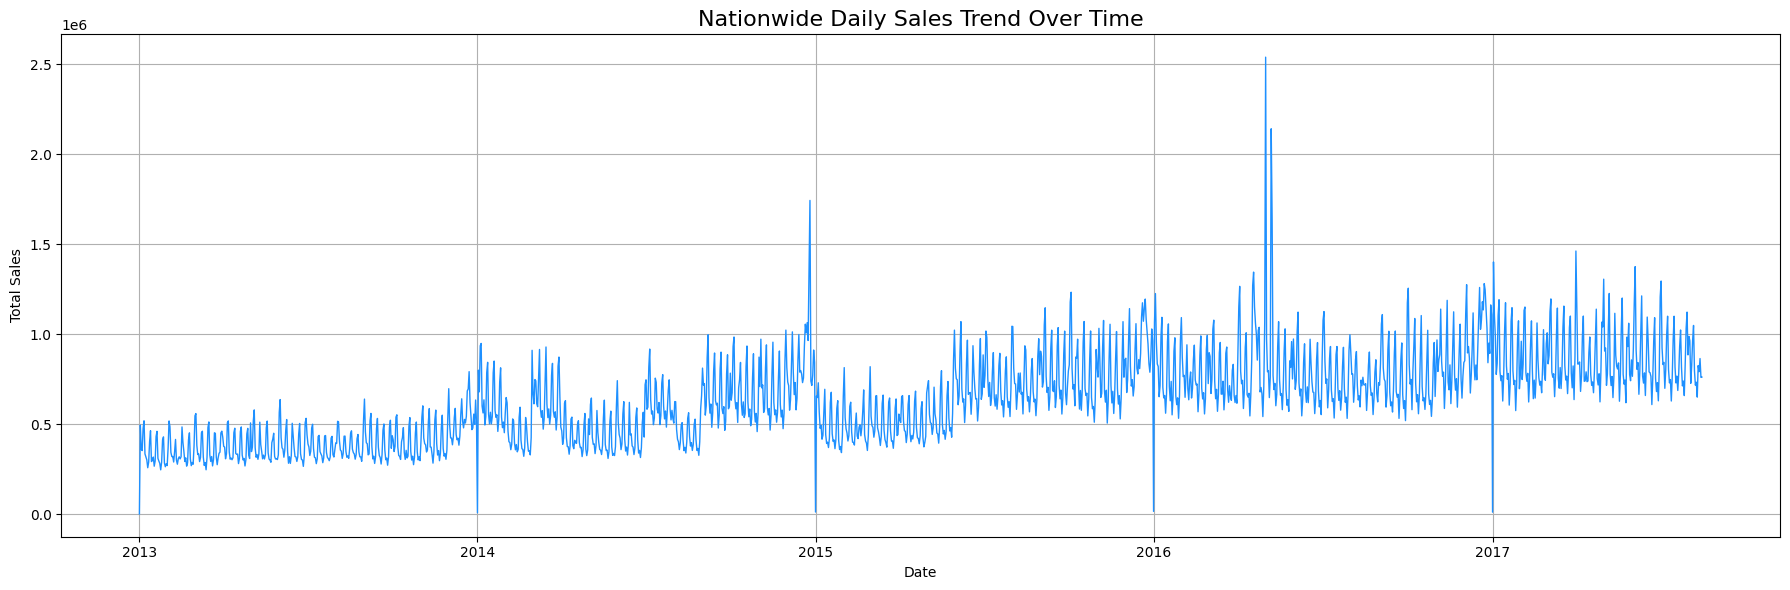

In [ ]:
#Exploratory Data Analysis (EDA)
#Sales Trend Over Time (Nationwide)
# Aggregate daily sales
daily_sales = train.groupby('date')['sales'].sum().reset_index()

# Plot
plt.figure(figsize=(18, 6))
plt.plot(daily_sales['date'], daily_sales['sales'], color='dodgerblue', linewidth=1)
plt.title('Nationwide Daily Sales Trend Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

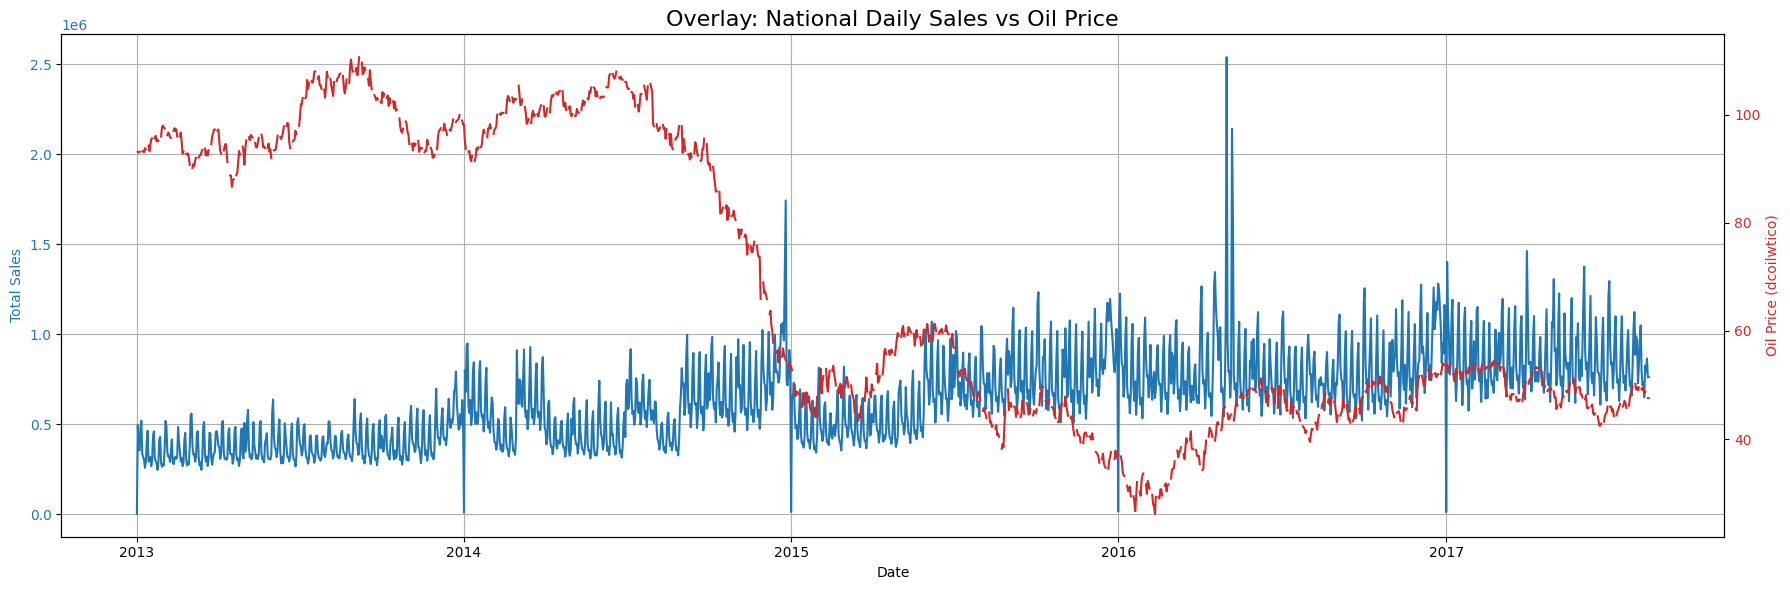

In [ ]:
#EDA A.1: Overlay Oil Price on National Sales Trend.
# Prepare oil-aggregated version just in case of duplicates
oil_daily = oil.copy().dropna().drop_duplicates(subset='date')

# Aggregate national sales per day
daily_sales = train.groupby('date')['sales'].sum().reset_index()

# Merge oil with daily sales for same-date comparison
merged = pd.merge(daily_sales, oil_daily, on='date', how='left')

# Plot sales + oil
fig, ax1 = plt.subplots(figsize=(18, 6))

# Primary y-axis: Sales
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales', color=color)
ax1.plot(merged['date'], merged['sales'], color=color, label='Total Sales')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Secondary y-axis: Oil Price
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Oil Price (dcoilwtico)', color=color)
ax2.plot(merged['date'], merged['dcoilwtico'], color=color, label='Oil Price')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Overlay: National Daily Sales vs Oil Price', fontsize=16)
fig.tight_layout()
plt.show()

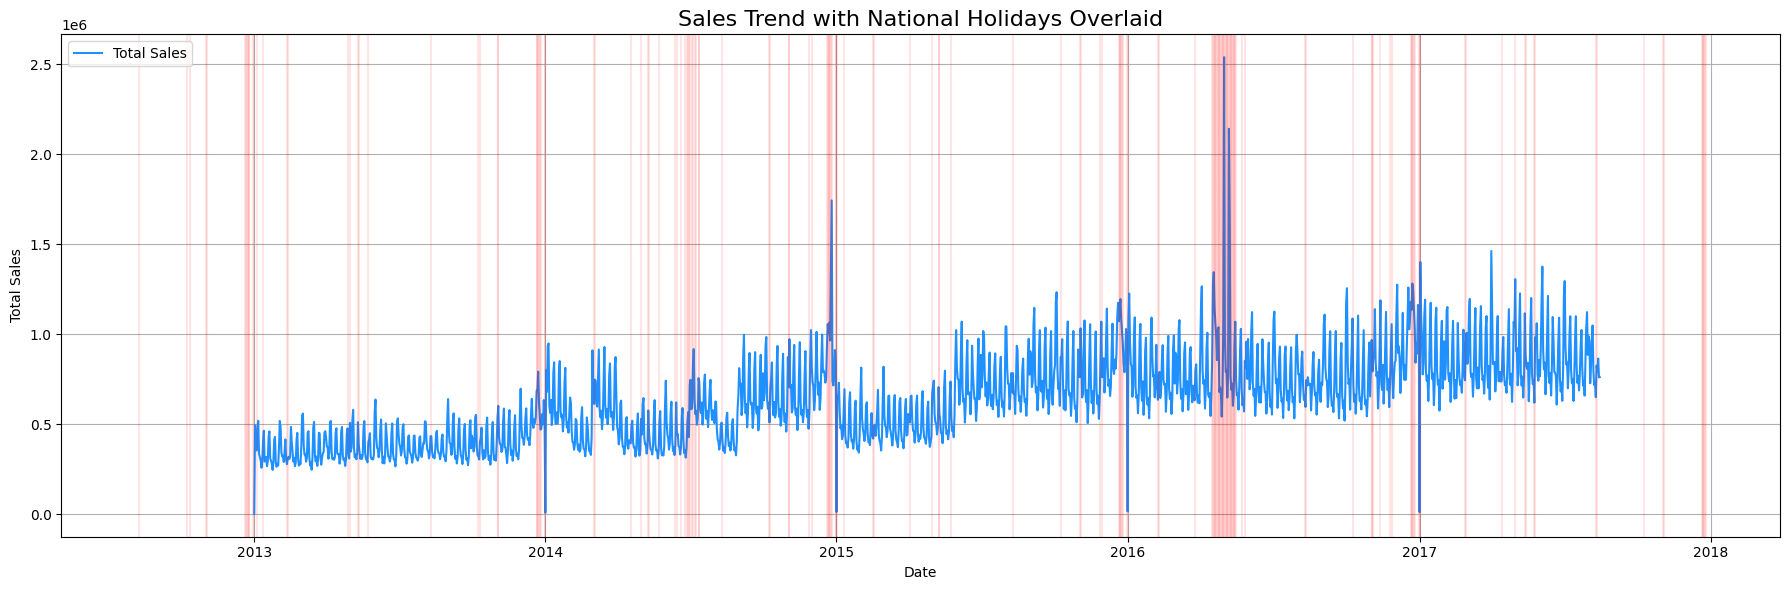

In [ ]:
# EDA A.2: Overlay Holidays on Sales Trend
# Reuse daily sales data
daily_sales = train.groupby('date')['sales'].sum().reset_index()

# Get unique national holiday dates
holiday_dates = holidays[holidays['locale'] == 'National']['date'].unique()

# Plot sales
plt.figure(figsize=(18, 6))
plt.plot(daily_sales['date'], daily_sales['sales'], label='Total Sales', color='dodgerblue')

# Overlay national holidays as vertical lines
for hdate in holiday_dates:
    plt.axvline(hdate, color='red', alpha=0.1)

plt.title('Sales Trend with National Holidays Overlaid', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

/tmp/ipython-input-19-649608283.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=family_sales, x='sales', y='family', palette='viridis')


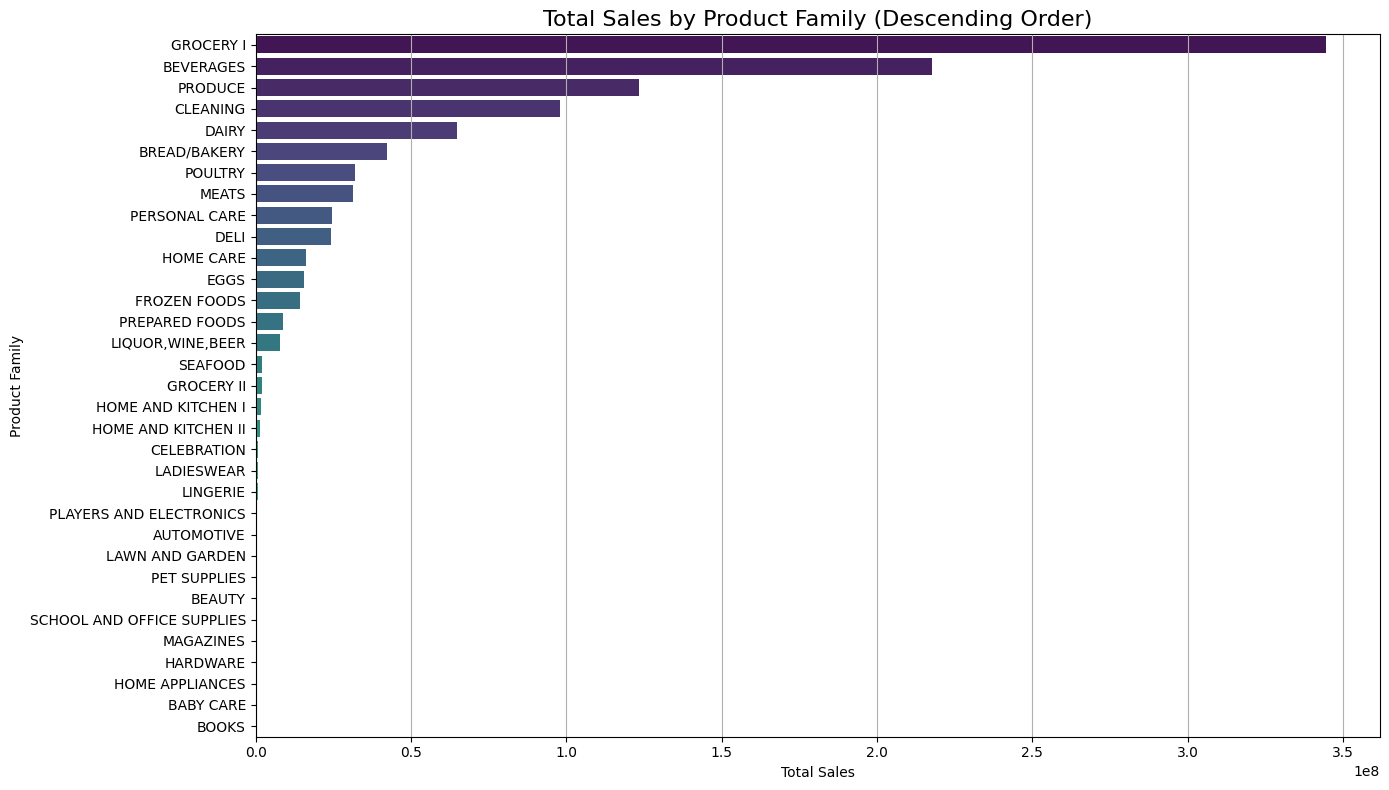

In [ ]:
#EDA B: Top Product Families by Total Sales
# Aggregate total sales by product family
family_sales = train.groupby('family')['sales'].sum().sort_values(ascending=False).reset_index()

# Plot top families
plt.figure(figsize=(14, 8))
sns.barplot(data=family_sales, x='sales', y='family', palette='viridis')

plt.title('Total Sales by Product Family (Descending Order)', fontsize=16)
plt.xlabel('Total Sales')
plt.ylabel('Product Family')
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()

/tmp/ipython-input-20-1772243277.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=store_sales, x='store_nbr', y='sales', palette='plasma')


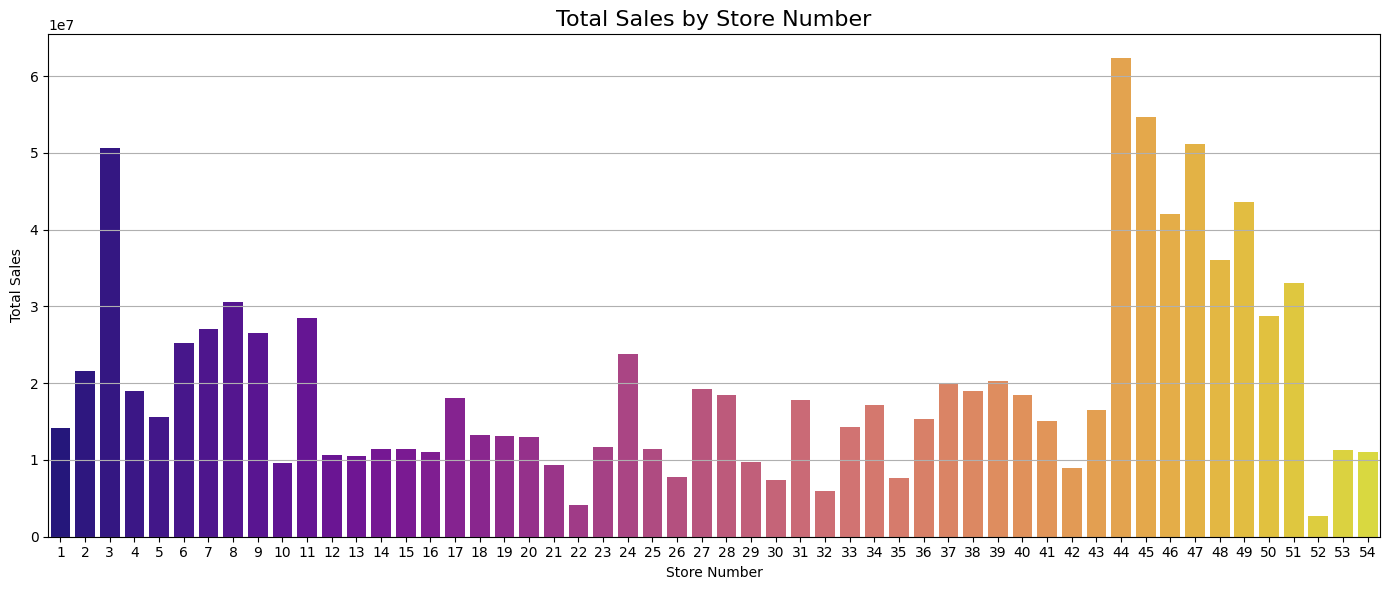

In [ ]:
#EDA C: Store-Level Sales Comparison
# Total sales by store
store_sales = train.groupby('store_nbr')['sales'].sum().sort_values(ascending=False).reset_index()

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=store_sales, x='store_nbr', y='sales', palette='plasma')

plt.title('Total Sales by Store Number', fontsize=16)
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

/tmp/ipython-input-21-1532682266.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekly_sales.index, y=weekly_sales.values, ax=axs[0], palette='crest')
/tmp/ipython-input-21-1532682266.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_sales.index, y=monthly_sales.values, ax=axs[1], palette='flare')


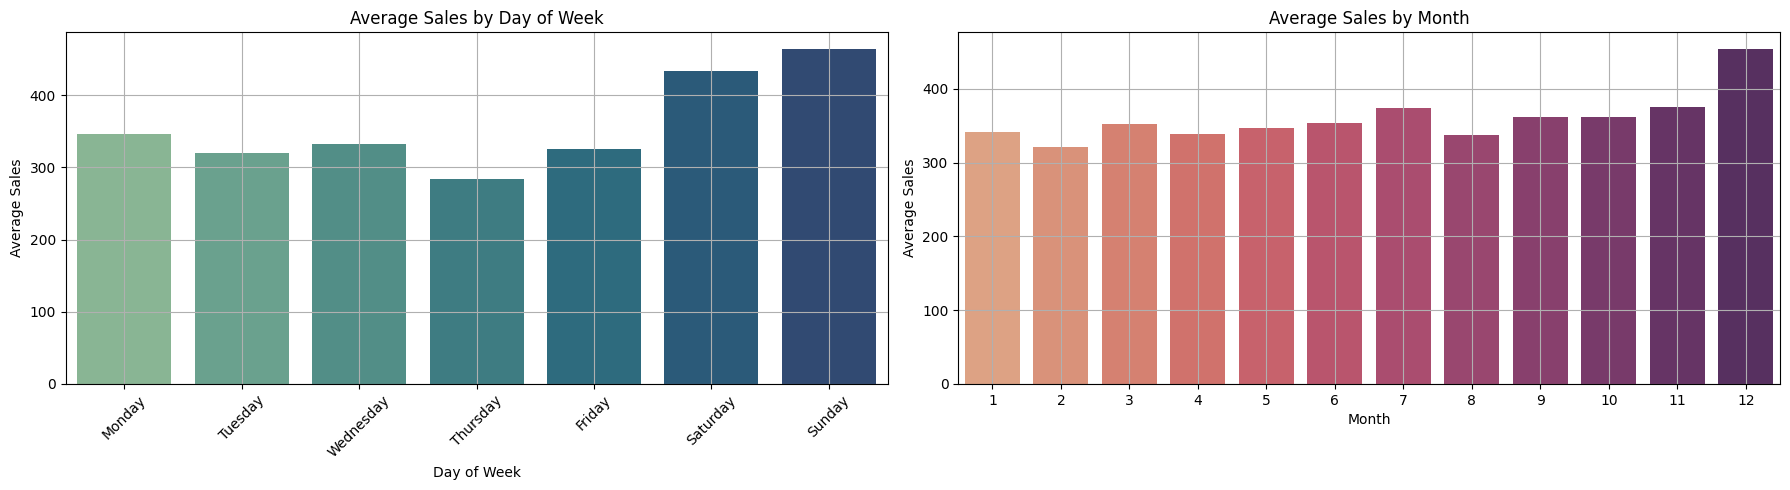

In [ ]:
#EDA D: Weekly and Monthly Seasonality Patterns
# Extract weekday and month
train['day_of_week'] = train['date'].dt.day_name()
train['month'] = train['date'].dt.month

# Weekly seasonality: Average sales by day of week
weekly_sales = train.groupby('day_of_week')['sales'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Monthly seasonality: Average sales by month
monthly_sales = train.groupby('month')['sales'].mean()

# Plot both
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Weekly
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, ax=axs[0], palette='crest')
axs[0].set_title('Average Sales by Day of Week')
axs[0].set_ylabel('Average Sales')
axs[0].set_xlabel('Day of Week')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)

# Monthly
sns.barplot(x=monthly_sales.index, y=monthly_sales.values, ax=axs[1], palette='flare')
axs[1].set_title('Average Sales by Month')
axs[1].set_ylabel('Average Sales')
axs[1].set_xlabel('Month')
axs[1].grid(True)

plt.tight_layout()
plt.show()

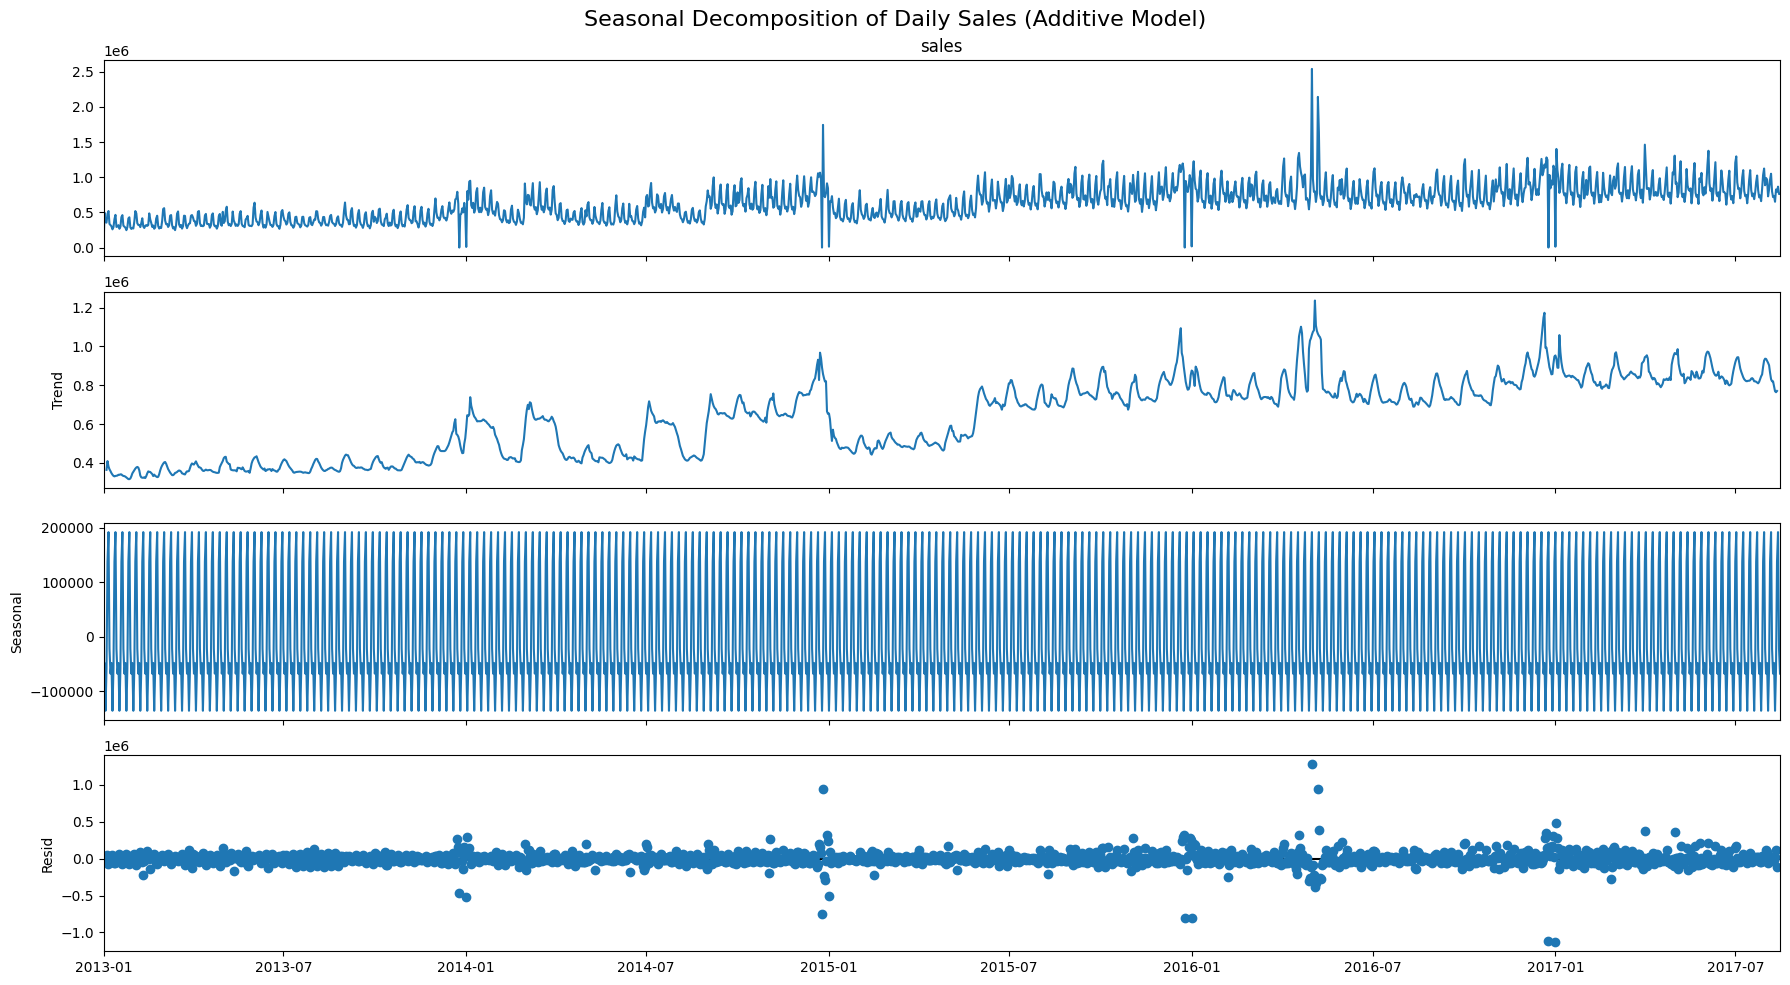

In [ ]:
#EDA D.1: Seasonal Decomposition of National Sales
from statsmodels.tsa.seasonal import seasonal_decompose

# Step 1: Prepare daily sales time series
daily_sales = train.groupby('date')['sales'].sum().asfreq('D')  # Ensure consistent daily frequency

# Step 2: Fill missing days (with 0 or interpolation)
daily_sales = daily_sales.fillna(0)

# Step 3: Decompose
decomp_result = seasonal_decompose(daily_sales, model='additive', period=7)  # weekly seasonality

# Step 4: Plot
fig = decomp_result.plot()
fig.set_size_inches(18, 10)
fig.suptitle('Seasonal Decomposition of Daily Sales (Additive Model)', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

/tmp/ipython-input-23-792452494.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=promo_effect, x='is_promoted', y='sales', palette='coolwarm')


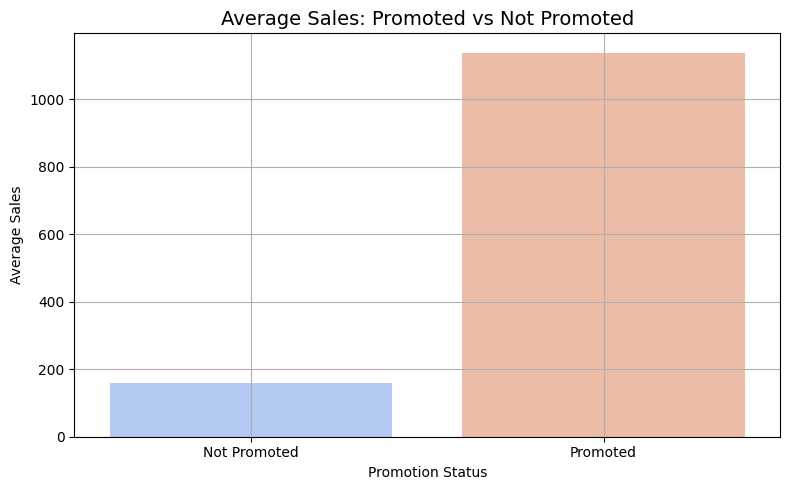

In [ ]:
#EDA E: Impact of Promotions on Sales
# Classify each row as promoted or not
train['is_promoted'] = train['onpromotion'] > 0

# Group by promotion flag
promo_effect = train.groupby('is_promoted')['sales'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=promo_effect, x='is_promoted', y='sales', palette='coolwarm')
plt.xticks([0, 1], ['Not Promoted', 'Promoted'])
plt.title('Average Sales: Promoted vs Not Promoted', fontsize=14)
plt.xlabel('Promotion Status')
plt.ylabel('Average Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-24-3235974418.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=promo_impact_family, y='family', x='Impact', palette='Spectral')


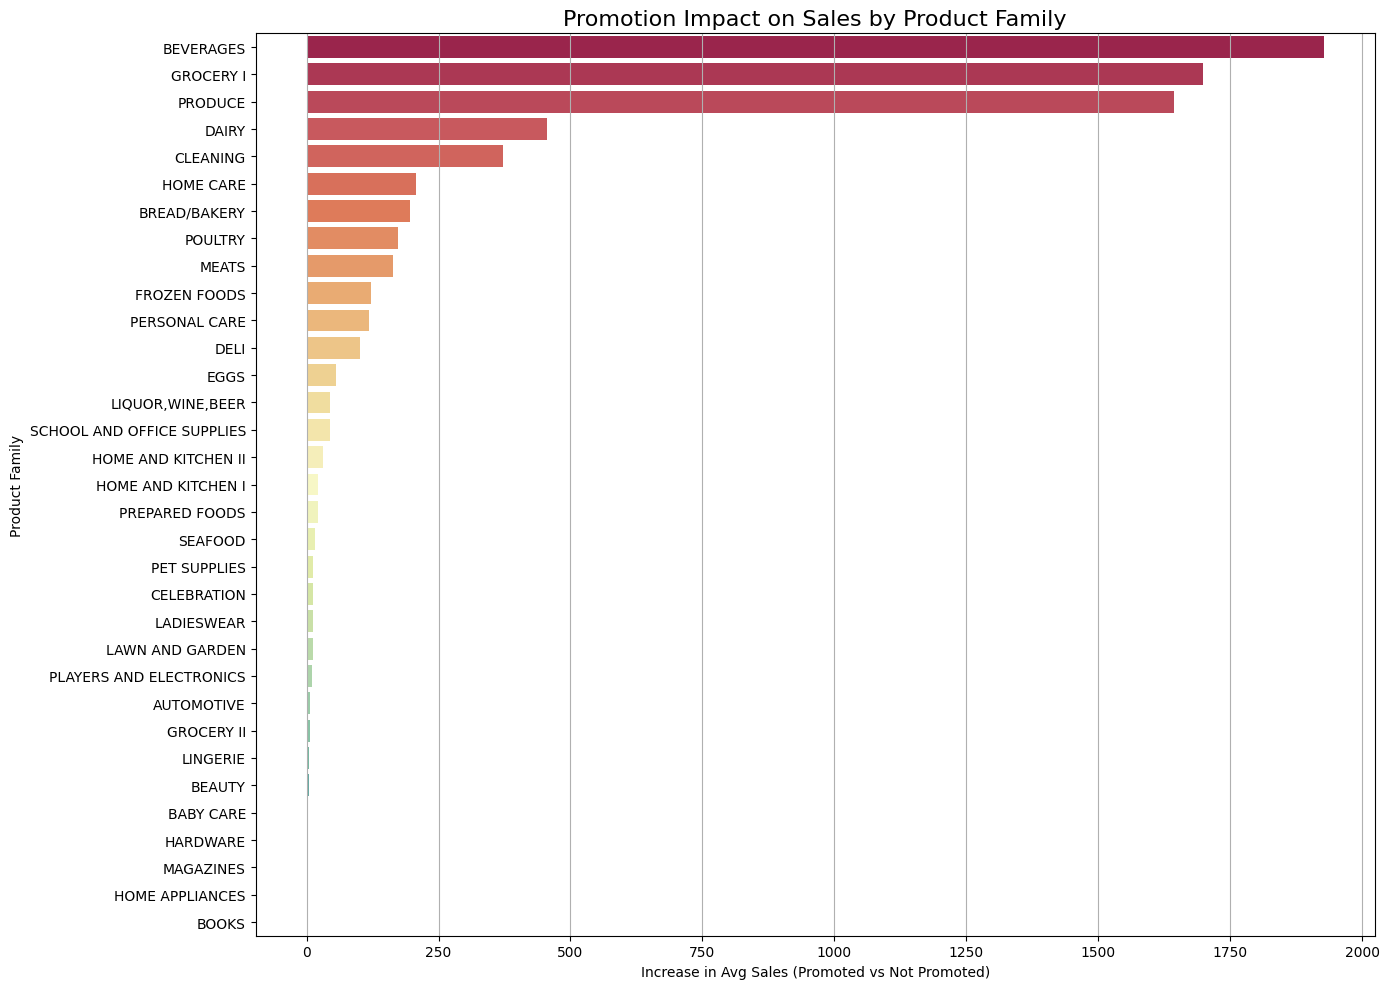

In [ ]:
#EDA E.1: Promotion Impact by Product Family
# Group by family and promotion flag
family_promo = train.copy()
family_promo['is_promoted'] = family_promo['onpromotion'] > 0
promo_impact_family = (
    family_promo.groupby(['family', 'is_promoted'])['sales']
    .mean().unstack().fillna(0)
).reset_index()

# Rename columns
promo_impact_family.columns = ['family', 'Not Promoted', 'Promoted']

# Add difference column
promo_impact_family['Impact'] = promo_impact_family['Promoted'] - promo_impact_family['Not Promoted']

# Sort by impact
promo_impact_family = promo_impact_family.sort_values('Impact', ascending=False)

# Plot
plt.figure(figsize=(14, 10))
sns.barplot(data=promo_impact_family, y='family', x='Impact', palette='Spectral')
plt.title('Promotion Impact on Sales by Product Family', fontsize=16)
plt.xlabel('Increase in Avg Sales (Promoted vs Not Promoted)')
plt.ylabel('Product Family')
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()

Pearson Correlation between Oil Price and Sales: -0.6829


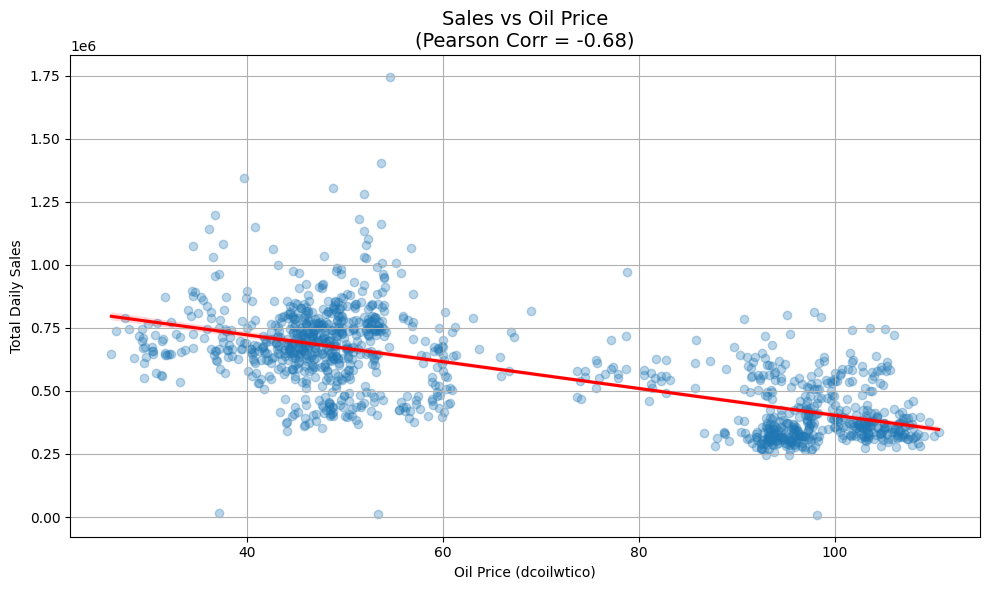

In [ ]:
 #EDA F: Correlation Between Oil Prices and Sales
 # Aggregate daily total sales
daily_sales = train.groupby('date')['sales'].sum().reset_index()

# Merge oil price into this
oil_merged = pd.merge(daily_sales, oil[['date', 'dcoilwtico']], on='date', how='left')

# Drop rows with missing oil data
oil_merged = oil_merged.dropna()

# Correlation calculation
correlation = oil_merged['sales'].corr(oil_merged['dcoilwtico'])
print(f"Pearson Correlation between Oil Price and Sales: {correlation:.4f}")

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=oil_merged, x='dcoilwtico', y='sales', scatter_kws={'alpha':0.3}, line_kws={"color": "red"})
plt.title(f'Sales vs Oil Price\n(Pearson Corr = {correlation:.2f})', fontsize=14)
plt.xlabel('Oil Price (dcoilwtico)')
plt.ylabel('Total Daily Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-26-1744821634.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=holiday_effect, x='is_holiday', y='sales', palette='Set2')


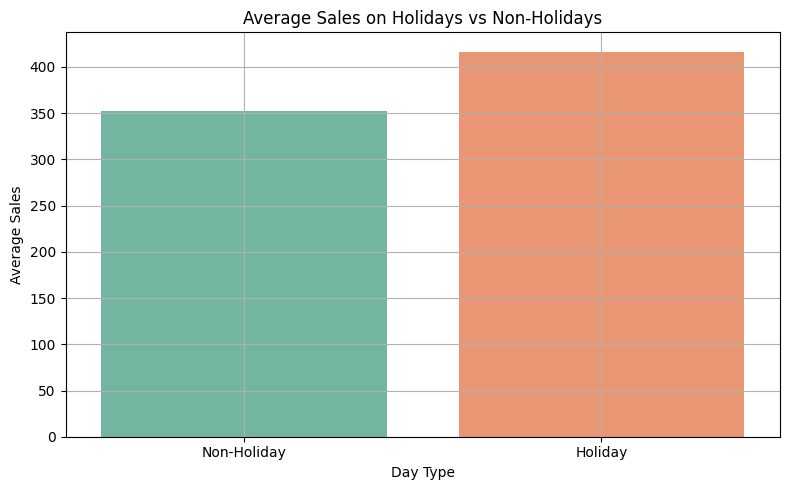

In [ ]:
#EDA G: Holiday vs Non-Holiday Sales
# Compare average sales: holiday vs non-holiday
holiday_effect = train.groupby('is_holiday')['sales'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=holiday_effect, x='is_holiday', y='sales', palette='Set2')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.title('Average Sales on Holidays vs Non-Holidays')
plt.xlabel('Day Type')
plt.ylabel('Average Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

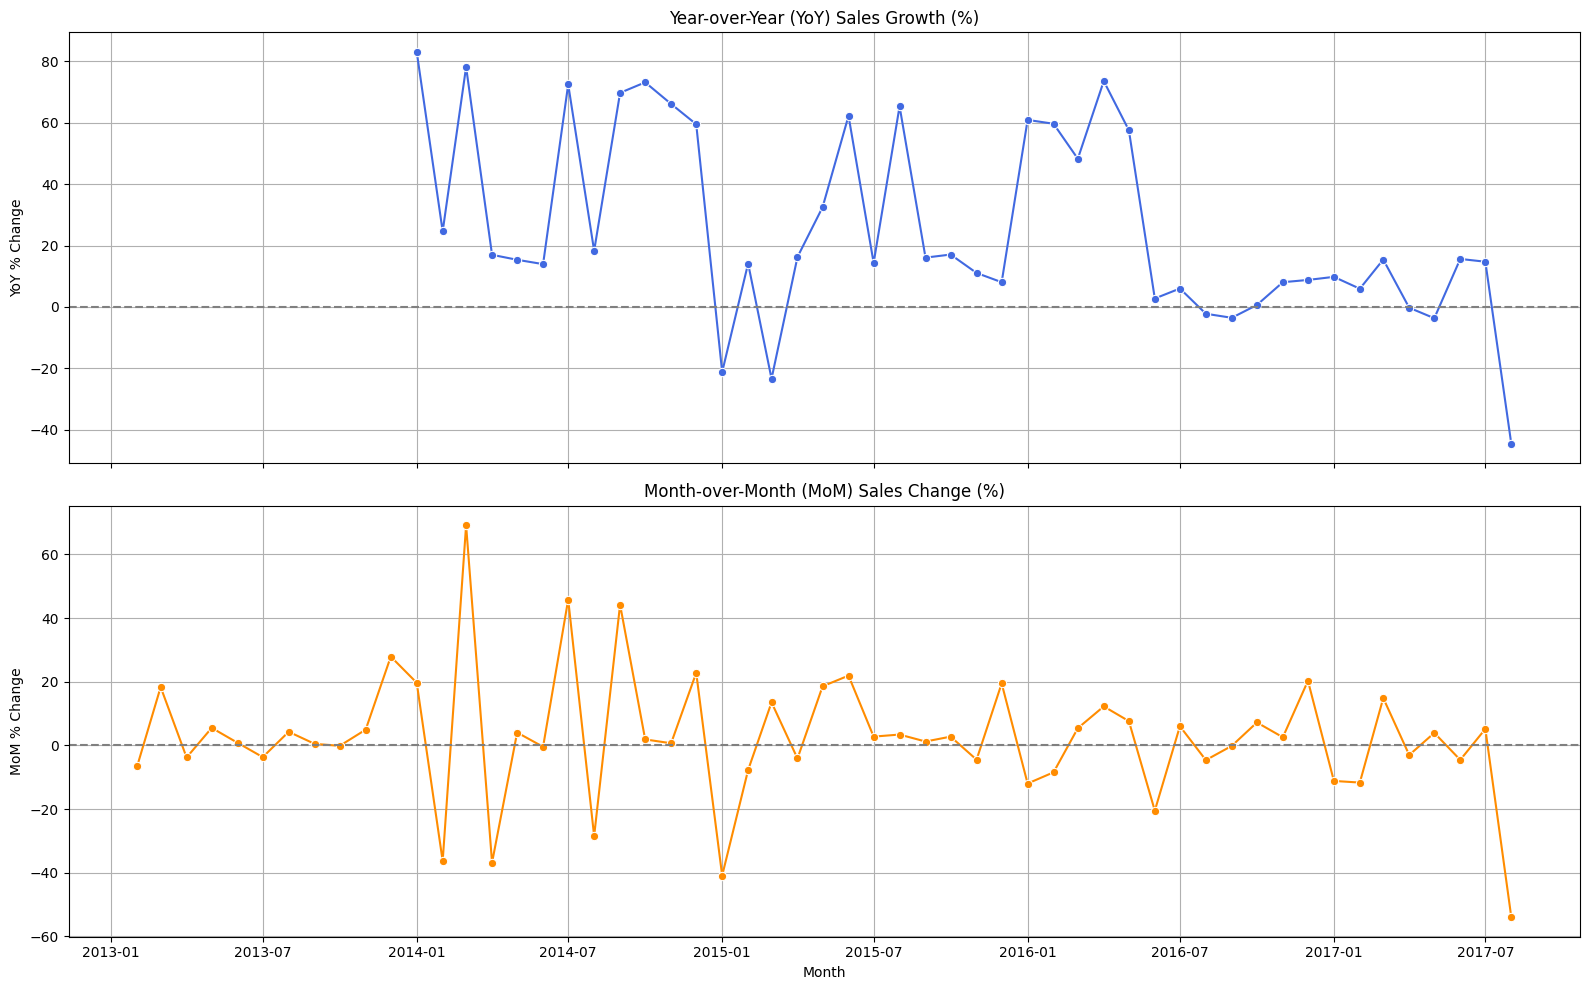

In [ ]:
#EDA H: Year-over-Year (YoY) & Month-over-Month (MoM) Sales Change
# Aggregate monthly sales
monthly_sales = train.groupby(train['date'].dt.to_period('M'))['sales'].sum()
monthly_sales.index = monthly_sales.index.to_timestamp()

# Calculate YoY and MoM
monthly_sales_df = monthly_sales.reset_index().rename(columns={'date': 'Month', 'sales': 'Total_Sales'})
monthly_sales_df['YoY_Change'] = monthly_sales_df['Total_Sales'].pct_change(12) * 100
monthly_sales_df['MoM_Change'] = monthly_sales_df['Total_Sales'].pct_change(1) * 100

# Plot YoY and MoM
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# YoY Change
sns.lineplot(data=monthly_sales_df, x='Month', y='YoY_Change', marker='o', ax=ax[0], color='royalblue')
ax[0].axhline(0, linestyle='--', color='gray')
ax[0].set_title('Year-over-Year (YoY) Sales Growth (%)')
ax[0].set_ylabel('YoY % Change')
ax[0].grid(True)

# MoM Change
sns.lineplot(data=monthly_sales_df, x='Month', y='MoM_Change', marker='o', ax=ax[1], color='darkorange')
ax[1].axhline(0, linestyle='--', color='gray')
ax[1].set_title('Month-over-Month (MoM) Sales Change (%)')
ax[1].set_ylabel('MoM % Change')
ax[1].set_xlabel('Month')
ax[1].grid(True)

plt.tight_layout()
plt.show()

/tmp/ipython-input-28-476980215.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=store_type_sales, x='type', y='sales', ax=ax[0], palette='Blues_d')
/tmp/ipython-input-28-476980215.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_sales, x='cluster', y='sales', ax=ax[1], palette='Purples')


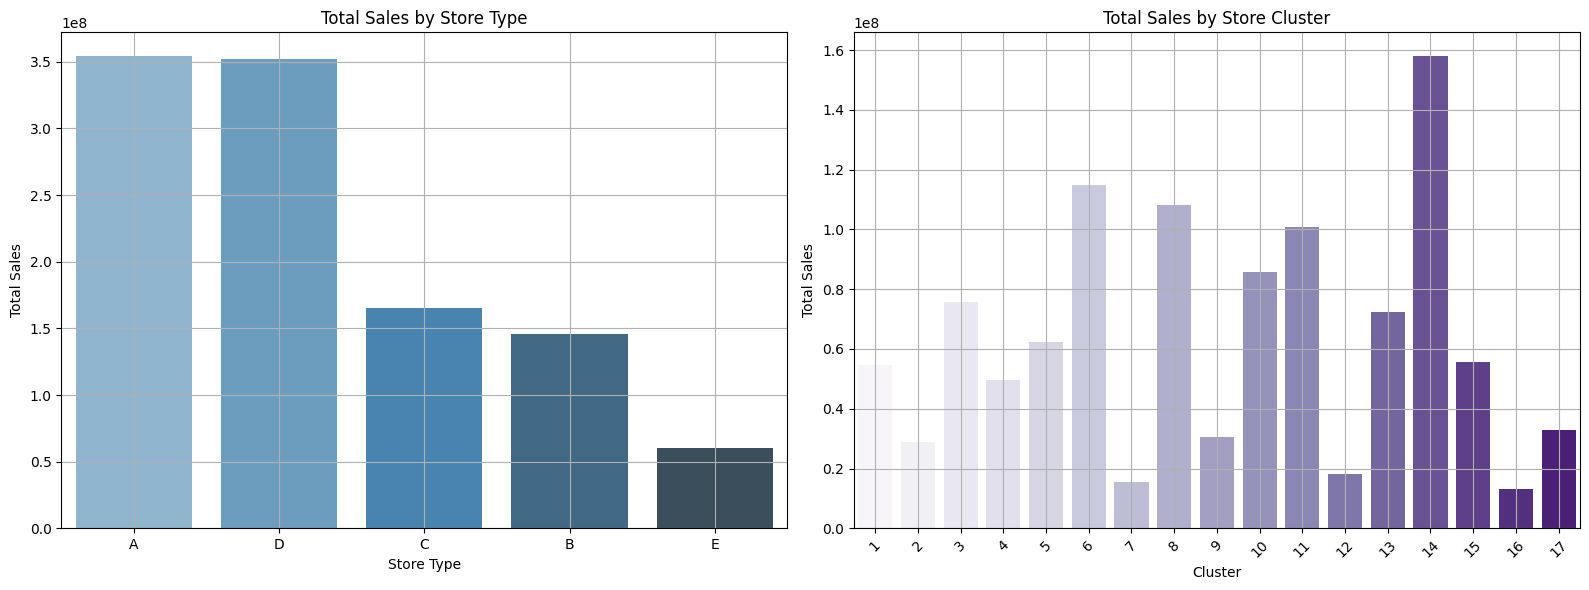

In [ ]:
#EDA I: Sales by Store Type and Cluster
# Aggregate by store type
store_type_sales = train.groupby('type')['sales'].sum().sort_values(ascending=False).reset_index()

# Aggregate by store cluster
cluster_sales = train.groupby('cluster')['sales'].sum().sort_values(ascending=False).reset_index()

# Plot both
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Store type
sns.barplot(data=store_type_sales, x='type', y='sales', ax=ax[0], palette='Blues_d')
ax[0].set_title('Total Sales by Store Type')
ax[0].set_xlabel('Store Type')
ax[0].set_ylabel('Total Sales')
ax[0].grid(True)

# Cluster
sns.barplot(data=cluster_sales, x='cluster', y='sales', ax=ax[1], palette='Purples')
ax[1].set_title('Total Sales by Store Cluster')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Total Sales')
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#Feature Engineering
#Step 1: Date-Based Features
# Base datetime features
for df in [train, test]:
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek  # 0=Monday
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

In [ ]:
'''These features will help:
   Capture weekend surges,
   Model month-end buying spikes
   Understand day-of-week variation'''

'These features will help:\n   Capture weekend surges,\n   Model month-end buying spikes\n   Understand day-of-week variation'

In [ ]:
#Step 2: Lag Features for sales
'''Objective:
Capture past behavior of sales per store_nbr & family
Key for all time series models
Helps predict future based on recent history
Lag features will create NaNs in the first lag days of each series
We'll handle these later (drop or impute before modeling)
Can use this same method on test set after retraining with full data'''

# Define lag days
lag_days = [1, 7, 14]

# Create lag features
for lag in lag_days:
    train[f'sales_lag_{lag}'] = train.groupby(['store_nbr', 'family'])['sales'].shift(lag)

In [ ]:
#Step 3: Rolling Window Features (Per Store-Family)
'''Objective:
Smooth out short-term fluctuations
Capture recent sales trends
Great for tree-based models and forecasting
Feature Examples:
rolling_mean_7: average of last 7 days’ sales
rolling_std_7: variation over last 7 days
Apply using groupby + .rolling()'''

# Rolling features over past 7 and 14 days
window_sizes = [7, 14]

for window in window_sizes:
    train[f'rolling_mean_{window}'] = (
        train.groupby(['store_nbr', 'family'])['sales']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
    )

    train[f'rolling_std_{window}'] = (
        train.groupby(['store_nbr', 'family'])['sales']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).std())
    )

In [ ]:
#Step 4: Promotion History Features
'''Objective:
Understand the temporal promotion pattern, since recent promotions often influence:
Current sales uplift
Customer buying momentum
Inventory dynamics'''

'Objective:\nUnderstand the temporal promotion pattern, since recent promotions often influence:\nCurrent sales uplift\nCustomer buying momentum\nInventory dynamics'

In [ ]:
'''key features
| Feature           | Description                                         |
| ----------------- | --------------------------------------------------- |
| `promo_lag_1`     | Was it promoted yesterday?                          |
| `promo_lag_7`     | Was it promoted last week?                          |
| `promo_rolling_7` | Count of promo days in last 7                       |
| `promo_streak_7`  | How many **consecutive days** recently on promotion |'''

'key features\n| Feature           | Description                                         |\n| ----------------- | --------------------------------------------------- |\n| `promo_lag_1`     | Was it promoted yesterday?                          |\n| `promo_lag_7`     | Was it promoted last week?                          |\n| `promo_rolling_7` | Count of promo days in last 7                       |\n| `promo_streak_7`  | How many **consecutive days** recently on promotion |'

In [ ]:
# Create binary promo flag (already done earlier, repeating for safety)
train['is_promoted'] = train['onpromotion'] > 0

# Lag promo flags
train['promo_lag_1'] = train.groupby(['store_nbr', 'family'])['is_promoted'].shift(1)
train['promo_lag_7'] = train.groupby(['store_nbr', 'family'])['is_promoted'].shift(7)

# Rolling count of promotions in past 7 days
train['promo_rolling_7'] = (
    train.groupby(['store_nbr', 'family'])['is_promoted']
    .transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).sum())
)

# Promo streaks: # of consecutive days recently promoted
def promo_streak(series):
    streak = 0
    result = []
    for val in series:
        if val:
            streak += 1
        else:
            streak = 0
        result.append(streak)
    return result

train['promo_streak_7'] = train.groupby(['store_nbr', 'family'])['is_promoted'].transform(promo_streak)

In [ ]:
#Step 5: Oil Feature Imputation & Smoothing
# Step 1: Add missing flag (optional)
for df in [train, test]:
    df['missing_oil'] = df['dcoilwtico'].isna().astype(int)

# Step 2: Fill missing oil values with forward-fill, then back-fill
for df in [train, test]:
    df['dcoilwtico'] = df['dcoilwtico'].ffill().bfill()

# Step 3: Smooth oil prices using 7-day moving average
for df in [train, test]:
    df['oil_trend_7'] = df['dcoilwtico'].rolling(window=7, min_periods=1).mean()

In [ ]:
#Step 6: Payday Feature (Ecuador-specific Insight)
#Mark 15th and last day of each month as paydays — which can influence spending in supermarkets.

# Function to detect last day of the month
def is_last_day_of_month(date):
    return (date + pd.Timedelta(days=1)).month != date.month

# Create payday flag: 15th or last day of month
for df in [train, test]:
    df['is_payday'] = ((df['date'].dt.day == 15) | df['date'].apply(is_last_day_of_month)).astype(int)

In [ ]:
#Step 7: Earthquake Period Flag
'''A 7.8 magnitude earthquake hit Ecuador on April 16, 2016.
It caused a major disruption in buying behavior, supply chains, and sales data.
Create a flag for a period after the earthquake (e.g., 4–6 weeks)
Help the model learn that this was a temporary anomaly.'''

# Define earthquake window (e.g., 6 weeks after April 16, 2016)
eq_start = pd.to_datetime('2016-04-16')
eq_end = eq_start + pd.Timedelta(days=42)  # 6 weeks

# Add flag
for df in [train, test]:
    df['post_earthquake'] = ((df['date'] >= eq_start) & (df['date'] <= eq_end)).astype(int)

In [ ]:
#Model Preparation & Baseline Modeling - Modeling Phase
#Step 1: Time-Based Train–Validation Split
'''Split the train dataset into:
Training Set: Data before a cutoff date
Validation Set: Recent period (e.g., last 2 weeks) for model testing
Why Time-Based?
Prevents data leakage
Mimics real-world forecasting (you always predict the future)
Recommended Split:
Final training day: 2017-07-31
Validation period: 2017-08-01 to 2017-08-15 (just before test set)'''

# Define validation cutoff
val_start_date = pd.to_datetime('2017-08-01')

# Split
train_set = train[train['date'] < val_start_date].copy()
val_set = train[train['date'] >= val_start_date].copy()

# Shapes
print("Train Set Shape:", train_set.shape)
print("Validation Set Shape:", val_set.shape)

# Check date ranges
print("Train Range:", train_set['date'].min(), "to", train_set['date'].max())
print("Validation Range:", val_set['date'].min(), "to", val_set['date'].max())

Train Set Shape: (2981550, 42)
Validation Set Shape: (26730, 42)
Train Range: 2013-01-01 00:00:00 to 2017-07-31 00:00:00
Validation Range: 2017-08-01 00:00:00 to 2017-08-15 00:00:00


In [ ]:
#Step 2: Define Evaluation Metric + Model Input Prep
from sklearn.metrics import mean_squared_log_error
import numpy as np

# RMSLE evaluation
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [ ]:
# LightGBM Modeling Prep
# Features to drop
drop_cols = ['id', 'date', 'sales']
# Define features and target
X_train = train_set.drop(columns=drop_cols)
X_val = val_set.drop(columns=drop_cols)
y_train = train_set['sales']
y_val = val_set['sales']

# Confirm no missing values
print("Train NaNs:", X_train.isna().sum().sum())
print("Validation NaNs:", X_val.isna().sum().sum())

Train NaNs: 312015
Validation NaNs: 0


In [ ]:
# Drop NaNs in train_set only
train_set_clean = train_set.dropna()

# Recreate modeling inputs
X_train = train_set_clean.drop(columns=drop_cols)
y_train = train_set_clean['sales']

print("Cleaned Train Shape:", X_train.shape)

Cleaned Train Shape: (2715702, 39)


In [ ]:
#Convert Categorical Columns Using Label Encoding
from sklearn.preprocessing import LabelEncoder

# Combine X_train and X_val to apply encoding consistently
combined = pd.concat([X_train, X_val], axis=0)

# Identify categorical columns
categorical_cols = combined.select_dtypes(include='object').columns

# Apply label encoding to each categorical column
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col].astype(str))
    encoders[col] = le

# Split back into train and val
X_train = combined.iloc[:len(X_train)].copy()
X_val = combined.iloc[len(X_train):].copy()

In [ ]:
#Step 3: Train Baseline LightGBM Model & Evaluate RMSLE
import lightgbm as lgb

# LightGBM Dataset
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'verbosity': -1,
    'random_state': 42
}

# Callbacks for early stopping and logging
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=100)
]

# Train the model
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    num_boost_round=1000,
    callbacks=callbacks
)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 224.775	valid_1's rmse: 215.696
[200]	training's rmse: 206.786	valid_1's rmse: 205.594
[300]	training's rmse: 195.279	valid_1's rmse: 201.071
[400]	training's rmse: 186.356	valid_1's rmse: 199.541
Early stopping, best iteration is:
[388]	training's rmse: 187.508	valid_1's rmse: 199.125


In [ ]:
#Predict & Evaluate RMSLE:
# Predict on validation
val_preds = model.predict(X_val, num_iteration=model.best_iteration)
val_preds = np.clip(val_preds, 0, None)  # clip negative predictions

# RMSLE score
val_rmsle = rmsle(y_val, val_preds)
print(f'Validation RMSLE: {val_rmsle:.4f}')

Validation RMSLE: 0.6207


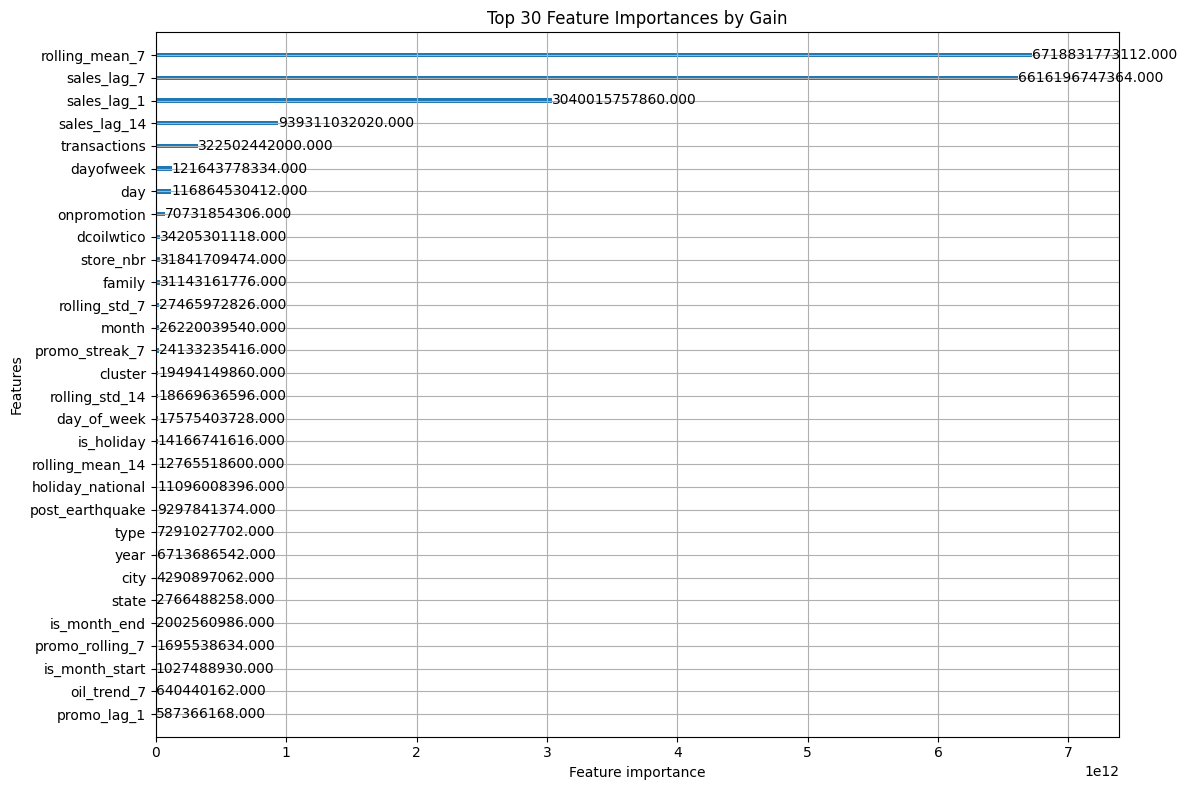

In [ ]:
#Step 4: Feature Importance Analysis
'''Understand which features were most influential in predicting sales.
LightGBM provides two types:
1.Gain: Total contribution of each feature to reducing error (most useful)
2.Split: How often a feature was used in splits (less useful early on)'''

# Plot top 30 important features by gain
import matplotlib.pyplot as plt
import lightgbm.plotting as lgb_plot

lgb.plot_importance(model, max_num_features=30, importance_type='gain', figsize=(12, 8), title='Top 30 Feature Importances by Gain')
plt.grid(True)
plt.tight_layout()
plt.show()

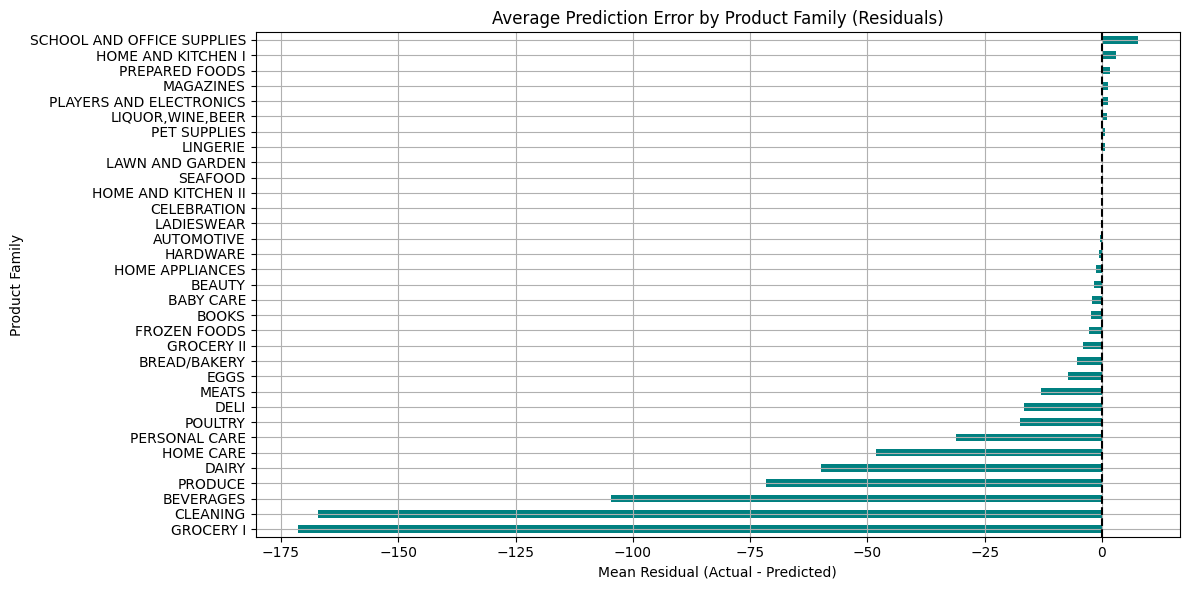

In [ ]:
#Step 5: Residual Error Analysis
# Add predictions and residuals to validation set
val_set = val_set.copy()
val_set['prediction'] = val_preds
val_set['residual'] = val_set['sales'] - val_set['prediction']

# Group residuals by product family
family_residuals = val_set.groupby('family')['residual'].mean().sort_values()

plt.figure(figsize=(12, 6))
family_residuals.plot(kind='barh', color='teal')
plt.axvline(0, linestyle='--', color='black')
plt.title('Average Prediction Error by Product Family (Residuals)')
plt.xlabel('Mean Residual (Actual - Predicted)')
plt.ylabel('Product Family')
plt.grid(True)
plt.tight_layout()
plt.show()

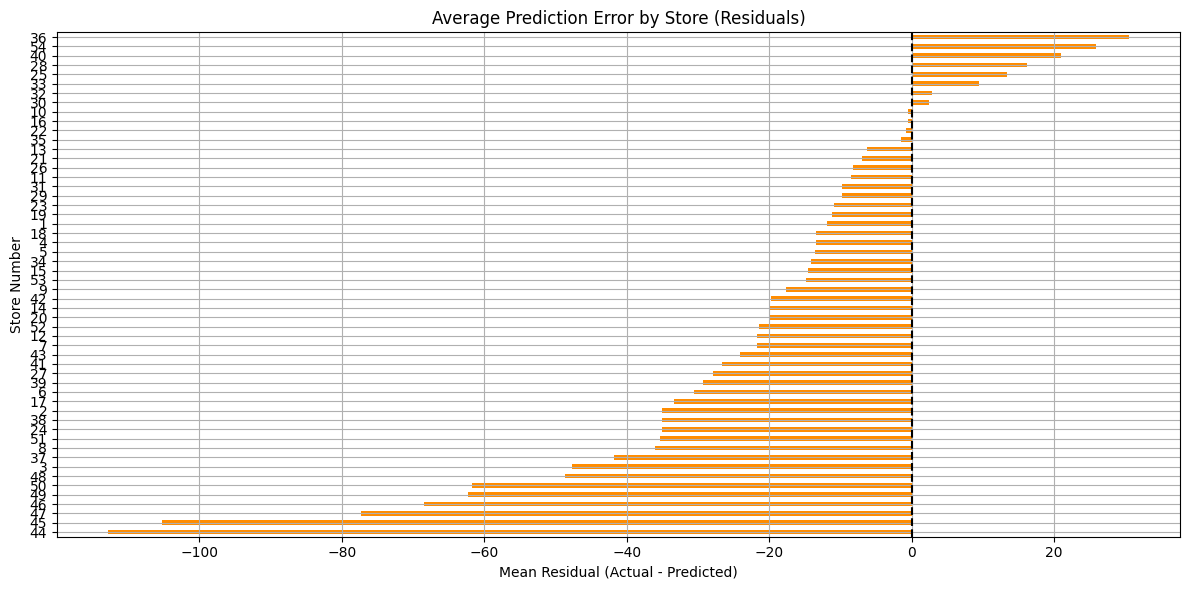

In [ ]:
#Step 5.2: Residuals by Store Number
# Group residuals by store number
store_residuals = val_set.groupby('store_nbr')['residual'].mean().sort_values()

plt.figure(figsize=(12, 6))
store_residuals.plot(kind='barh', color='darkorange')
plt.axvline(0, linestyle='--', color='black')
plt.title('Average Prediction Error by Store (Residuals)')
plt.xlabel('Mean Residual (Actual - Predicted)')
plt.ylabel('Store Number')
plt.grid(True)
plt.tight_layout()
plt.show()

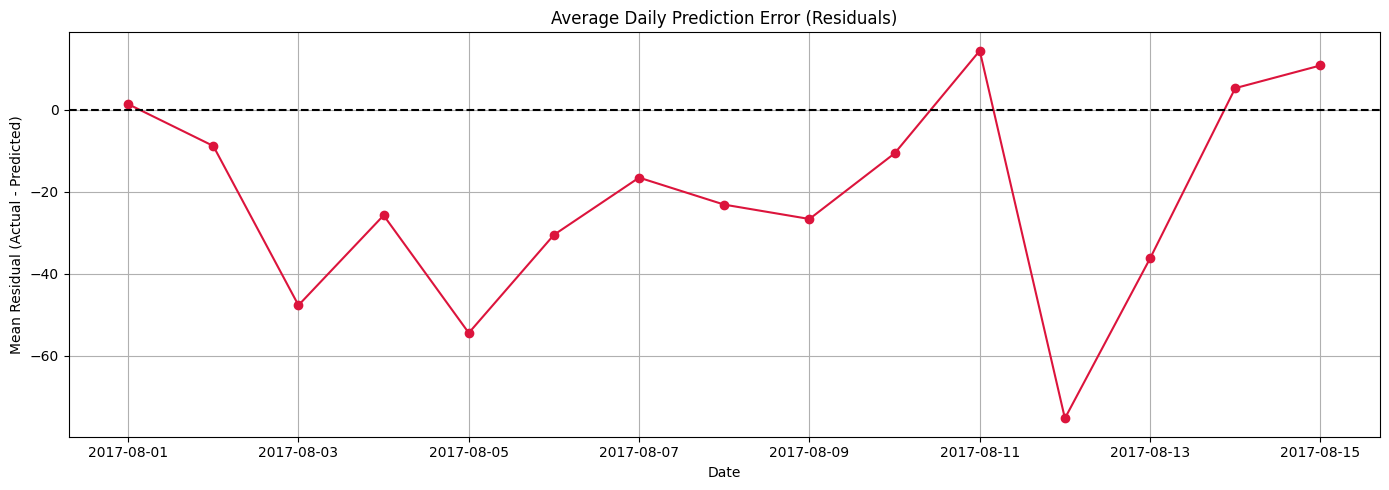

In [ ]:
#Step 5.3: Residuals by Date
# Group residuals by date
date_residuals = val_set.groupby('date')['residual'].mean()

plt.figure(figsize=(14, 5))
plt.plot(date_residuals.index, date_residuals.values, marker='o', color='crimson')
plt.axhline(0, linestyle='--', color='black')
plt.title('Average Daily Prediction Error (Residuals)')
plt.xlabel('Date')
plt.ylabel('Mean Residual (Actual - Predicted)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Model Tuning & Stacking
#Step 1: Hyperparameter Tuning with LightGBM
#Step 1 – Setup Grid Search
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# Define model
lgbm_model = LGBMRegressor(
    objective='regression',
    random_state=42,
    n_estimators=200  # Keep small for faster tuning
)

# Parameter grid to test
param_grid = {
    'num_leaves': [31, 63],
    'max_depth': [6, 10, -1],
    'learning_rate': [0.05, 0.1],
    'min_child_samples': [20, 30],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # approximates RMSE
    cv=3,
    verbose=1,
    n_jobs=-1
)

In [ ]:
#Step 1.1: Run Grid Search on a Sample (Fast Version)
# Sample a subset for fast tuning
sample_size = 100_000
X_train_sample = X_train.sample(sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# Fit GridSearchCV
grid_search.fit(X_train_sample, y_train_sample)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=LGBMRegressor(n_estimators=200, objective='regression',
                                     random_state=42),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8],
                         'learning_rate': [0.05, 0.1], 'max_depth': [6, 10, -1],
                         'min_child_samples': [20, 30], 'num_leaves': [31, 63],
                         'subsample': [0.8]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [ ]:
# Best hyperparameters and score
print("Best Params:", grid_search.best_params_)
print("Best RMSE Score (negative):", -grid_search.best_score_)

Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 20, 'num_leaves': 31, 'subsample': 0.8}
Best RMSE Score (negative): 222.18152900817935


In [ ]:
#Step 1.2: Retrain Final LightGBM on Full Data (with Best Params)
from lightgbm import early_stopping, log_evaluation

# Final model with best hyperparameters
final_model = LGBMRegressor(
    objective='regression',
    learning_rate=0.1,
    max_depth=10,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_estimators=1000
)

# Fit model with callbacks
final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 215.449	valid_0's l2: 46418.1
[200]	valid_0's rmse: 205.235	valid_0's l2: 42121.2
[300]	valid_0's rmse: 200.933	valid_0's l2: 40374.1
[400]	valid_0's rmse: 197.986	valid_0's l2: 39198.3
[500]	valid_0's rmse: 197.927	valid_0's l2: 39175.2
Early stopping, best iteration is:
[519]	valid_0's rmse: 196.855	valid_0's l2: 38752.1


LGBMRegressor(colsample_bytree=0.8, max_depth=10, n_estimators=1000,
              objective='regression', random_state=42, subsample=0.8)

In [ ]:
# Predict & RMSLE
val_preds_tuned = final_model.predict(X_val, num_iteration=final_model.best_iteration_)
val_preds_tuned = np.clip(val_preds_tuned, 0, None)

val_rmsle_tuned = rmsle(y_val, val_preds_tuned)
print(f'Final RMSLE after Tuning: {val_rmsle_tuned:.4f}')

Final RMSLE after Tuning: 0.6154


In [ ]:
#Model 2 - Train an "XGBoost Model" on the Same Features
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-rmse:1037.57093	val-rmse:1121.27630
[80]	train-rmse:135.47277	val-rmse:199.89710


In [ ]:
#Predict & Evaluate RMSLE:
# Predict
xgb_preds = xgb_model.predict(dval)
xgb_preds = np.clip(xgb_preds, 0, None)

# Compute RMSLE
from sklearn.metrics import mean_squared_log_error
xgb_rmsle = np.sqrt(mean_squared_log_error(y_val, xgb_preds))
print(f'XGBoost RMSLE (using DMatrix): {xgb_rmsle:.4f}')

XGBoost RMSLE (using DMatrix): 0.4573


In [ ]:
#Test Set Prediction
#Prepare the Test Data
# Show basic info of test set
print("Test Shape:", test.shape)
print("\nColumns in Test:")
print(test.columns)

test.head()

Test Shape: (28512, 28)

Columns in Test:
Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'dcoilwtico',
       'city', 'state', 'type', 'cluster', 'transactions', 'missing_trans',
       'trans_imputed', 'holiday_national', 'holiday_regional',
       'holiday_local', 'is_holiday', 'day', 'month', 'year', 'dayofweek',
       'is_weekend', 'is_month_start', 'is_month_end', 'missing_oil',
       'oil_trend_7', 'is_payday', 'post_earthquake'],
      dtype='object')


,id,date,store_nbr,family,onpromotion,dcoilwtico,city,state,type,cluster,...,month,year,dayofweek,is_weekend,is_month_start,is_month_end,missing_oil,oil_trend_7,is_payday,post_earthquake
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.8,Quito,Pichincha,D,13,...,8,2017,2,0,0,0,0,46.8,0,0
1,3000889,2017-08-16,1,BABY CARE,0,46.8,Quito,Pichincha,D,13,...,8,2017,2,0,0,0,0,46.8,0,0
2,3000890,2017-08-16,1,BEAUTY,2,46.8,Quito,Pichincha,D,13,...,8,2017,2,0,0,0,0,46.8,0,0
3,3000891,2017-08-16,1,BEVERAGES,20,46.8,Quito,Pichincha,D,13,...,8,2017,2,0,0,0,0,46.8,0,0
4,3000892,2017-08-16,1,BOOKS,0,46.8,Quito,Pichincha,D,13,...,8,2017,2,0,0,0,0,46.8,0,0


In [ ]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'dcoilwtico', 'city', 'state', 'type', 'cluster', 'transactions',
       'missing_trans', 'trans_imputed', 'holiday_national',
       'holiday_regional', 'holiday_local', 'is_holiday', 'day_of_week',
       'month', 'is_promoted', 'day', 'year', 'dayofweek', 'is_weekend',
       'is_month_start', 'is_month_end', 'sales_lag_1', 'sales_lag_7',
       'sales_lag_14', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14',
       'rolling_std_14', 'promo_lag_1', 'promo_lag_7', 'promo_rolling_7',
       'promo_streak_7', 'missing_oil', 'oil_trend_7', 'is_payday',
       'post_earthquake'],
      dtype='object')

In [ ]:
#Preparing test set
#Missing features processing in test set - Final Test Feature Engineering — Lag, Rolling, Promo History
#Recreate all lag-based and rolling features for the test set
#Must use historical train data for correct test feature values

#step 1: Concatenate train & test to calculate features together
# Backup original test ID column
test_ids = test['id']

# Add 'sales' column to test with NaNs (needed for rolling/lagging)
test['sales'] = np.nan

# Add placeholder is_promoted column for test
test['is_promoted'] = test['onpromotion'] > 0

# Combine train + test for consistent feature engineering
combined = pd.concat([train, test], axis=0, ignore_index=True)
combined = combined.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

print("Combined shape:", combined.shape)

Combined shape: (3036792, 42)


In [ ]:
 #Step 2: Generate Lag, Rolling, and Promo History Features (Train + Test)
 # Define lag days and rolling windows
lag_days = [1, 7, 14]
window_sizes = [7, 14]

# Sales lag features
for lag in lag_days:
    combined[f'sales_lag_{lag}'] = combined.groupby(['store_nbr', 'family'])['sales'].shift(lag)

# Rolling sales stats
for window in window_sizes:
    combined[f'rolling_mean_{window}'] = (
        combined.groupby(['store_nbr', 'family'])['sales']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
    )

    combined[f'rolling_std_{window}'] = (
        combined.groupby(['store_nbr', 'family'])['sales']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).std())
    )

# Promo lag features
combined['promo_lag_1'] = combined.groupby(['store_nbr', 'family'])['is_promoted'].shift(1)
combined['promo_lag_7'] = combined.groupby(['store_nbr', 'family'])['is_promoted'].shift(7)

# Promo rolling count (7 days)
combined['promo_rolling_7'] = (
    combined.groupby(['store_nbr', 'family'])['is_promoted']
    .transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).sum())
)

# Promo streak function
def promo_streak(series):
    streak = 0
    result = []
    for val in series:
        if val:
            streak += 1
        else:
            streak = 0
        result.append(streak)
    return result

combined['promo_streak_7'] = combined.groupby(['store_nbr', 'family'])['is_promoted'].transform(promo_streak)

In [ ]:
#Step 3: Extract Final Test Set with Features
# Extract test portion by using the known test IDs
final_test = combined[combined['id'].isin(test_ids)].copy()

# Confirm shape
print("Final test shape:", final_test.shape)

# Drop columns not used in training (like raw 'sales' column)
X_test = final_test[X_train.columns]

# Confirm column match
print("X_test columns match X_train:", list(X_test.columns) == list(X_train.columns))

Final test shape: (28512, 42)
X_test columns match X_train: True


In [ ]:
X_test.columns

Index(['store_nbr', 'family', 'onpromotion', 'dcoilwtico', 'city', 'state',
       'type', 'cluster', 'transactions', 'missing_trans', 'trans_imputed',
       'holiday_national', 'holiday_regional', 'holiday_local', 'is_holiday',
       'day_of_week', 'month', 'is_promoted', 'day', 'year', 'dayofweek',
       'is_weekend', 'is_month_start', 'is_month_end', 'sales_lag_1',
       'sales_lag_7', 'sales_lag_14', 'rolling_mean_7', 'rolling_std_7',
       'rolling_mean_14', 'rolling_std_14', 'promo_lag_1', 'promo_lag_7',
       'promo_rolling_7', 'promo_streak_7', 'missing_oil', 'oil_trend_7',
       'is_payday', 'post_earthquake'],
      dtype='object')

In [ ]:
X_train.columns

Index(['store_nbr', 'family', 'onpromotion', 'dcoilwtico', 'city', 'state',
       'type', 'cluster', 'transactions', 'missing_trans', 'trans_imputed',
       'holiday_national', 'holiday_regional', 'holiday_local', 'is_holiday',
       'day_of_week', 'month', 'is_promoted', 'day', 'year', 'dayofweek',
       'is_weekend', 'is_month_start', 'is_month_end', 'sales_lag_1',
       'sales_lag_7', 'sales_lag_14', 'rolling_mean_7', 'rolling_std_7',
       'rolling_mean_14', 'rolling_std_14', 'promo_lag_1', 'promo_lag_7',
       'promo_rolling_7', 'promo_streak_7', 'missing_oil', 'oil_trend_7',
       'is_payday', 'post_earthquake'],
      dtype='object')

In [ ]:
#Step 4: Predict on Test Set
# Fix dtype issues by converting object columns to category
cat_cols = ['family', 'city', 'state', 'type', 'day_of_week', 'promo_lag_1', 'promo_lag_7']
for col in cat_cols:
    X_test[col] = X_test[col].astype('category')

/tmp/ipython-input-64-1446007814.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')
/tmp/ipython-input-64-1446007814.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')
/tmp/ipython-input-64-1446007814.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [ ]:
# create DMatrix with categorical support
dtest = xgb.DMatrix(X_test, enable_categorical=True)

# Predict
test_preds = xgb_model.predict(dtest)
test_preds = np.clip(test_preds, 0, None)

# Submission DataFrame
submission = pd.DataFrame({
    'id': final_test['id'],
    'sales': test_preds
})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,sales
1688,3000888,5.637013
1689,3002670,1075.437500
1690,3004452,1519.628784
1691,3006234,1589.186157
1692,3008016,1470.118286


In [ ]:
#from google.colab import files
#files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Step: Add Model Explainability with SHAP -  to enhance model transparency using SHAP (SHapley Additive exPlanations)
#!pip install shap --quiet

/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


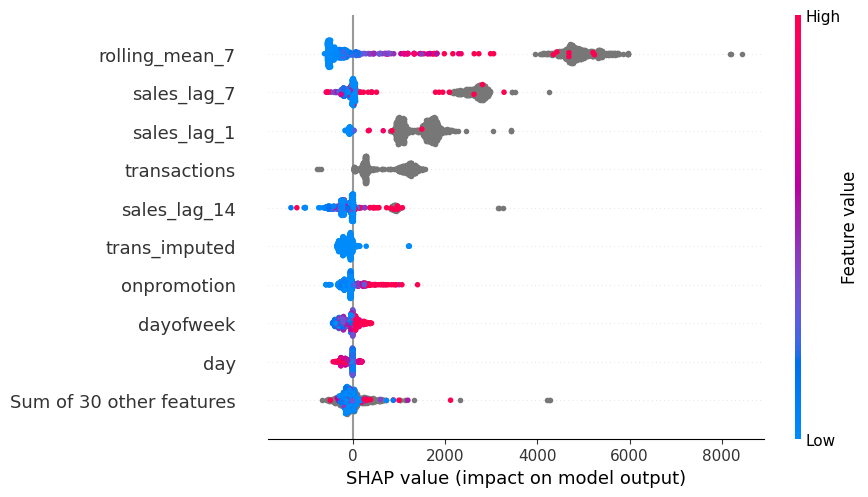

In [ ]:
# Step 1: Import libraries
import shap
from sklearn.preprocessing import LabelEncoder

# Step 2: Make a copy to preserve original
X_shap = X_test.copy()

# Step 3: Convert all categorical columns to numeric
cat_cols = X_shap.select_dtypes(include='category').columns

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X_shap[col] = le.fit_transform(X_shap[col])
    le_dict[col] = le

# Step 4: Sample
X_sample = X_shap.sample(1000, random_state=42)

# Step 5: Create SHAP Explainer and Compute SHAP Values
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_sample)

# Step 6: Global Feature Importance Plot (SHAP summary)
shap.plots.beeswarm(shap_values)

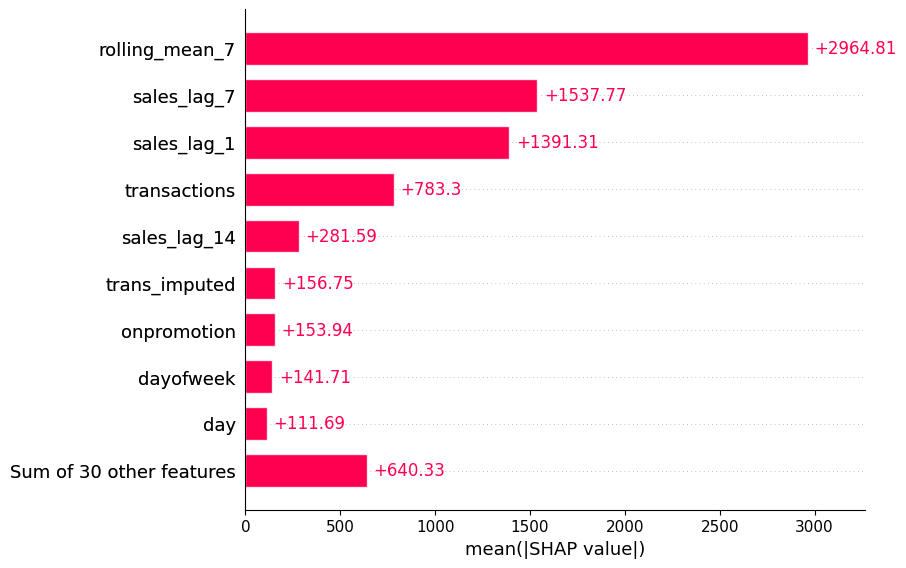

In [ ]:
# SHAP Bar Plot (Global feature importance by mean absolute SHAP value)
shap.plots.bar(shap_values)

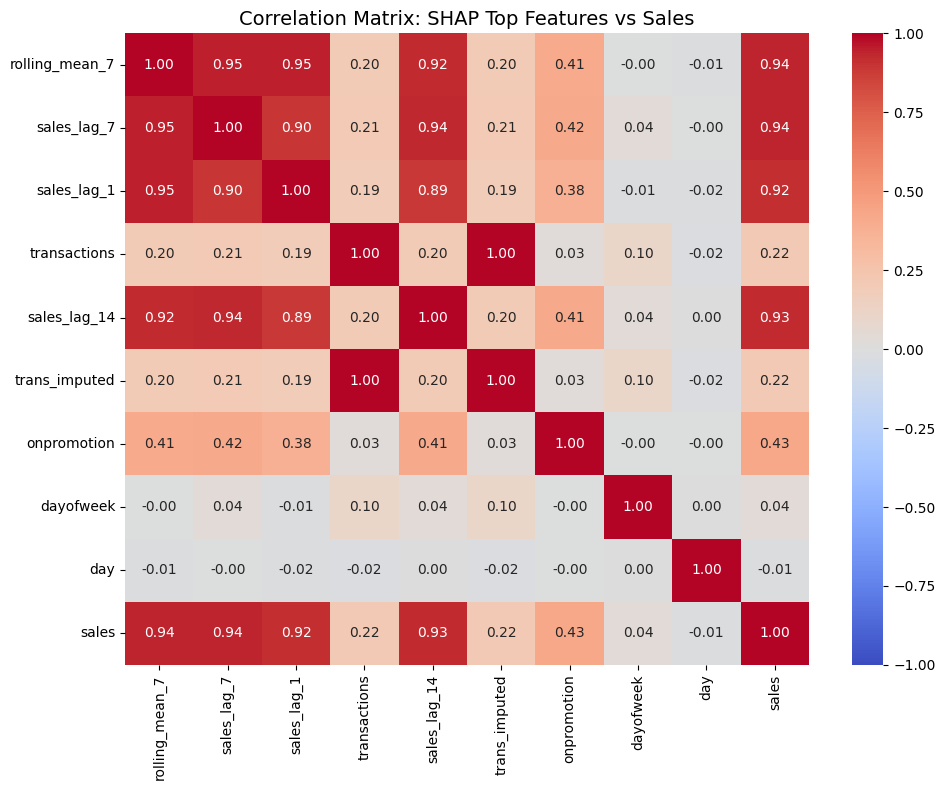

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of top SHAP features from your beeswarm plot
top_features = [
    'rolling_mean_7', 'sales_lag_7', 'sales_lag_1',
    'transactions', 'sales_lag_14', 'trans_imputed',
    'onpromotion', 'dayofweek', 'day'
]

# Add the target column to the correlation analysis
corr_df = train[top_features + ['sales']].copy()

# Drop NaNs (especially in lag features)
corr_df = corr_df.dropna()

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix: SHAP Top Features vs Sales", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
#Dashboarding - files generation
train.to_csv('enriched_train.csv', index=False)

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
test.to_csv('test_full_features.csv', index=False)

In [ ]:
store_cols = ['store_nbr', 'city', 'state', 'type', 'cluster']
stores = test[store_cols].drop_duplicates()
stores.to_csv('stores.csv', index=False)

In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('enriched_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('test_full_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('stores.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>